In [36]:
#@title Installing PyTorch and Dependencies

%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Enable interactive plotting
%matplotlib inline

In [38]:
#@title Define Hyperparameters

# CNN doesn't need input_size and hidden_size like FC network
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step (learning rate)

In [39]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [40]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [41]:
#@title Define CNN model class using Sequential

class Net(nn.Module):
  def __init__(self, num_classes):
    super(Net, self).__init__()
    
    # Convolutional feature extractor using Sequential
    self.features = nn.Sequential(
      # Conv Block 1: 1 -> 4 channels, 28x28 -> 28x28
      nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
      
      # Conv Block 2: 4 -> 64 channels, 14x14 -> 14x14
      nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7

      # Conv Block 3: 16 -> 32 channels, 7x7 -> 7x7
      nn.Conv2d(16, 28, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
    )
    
    # Fully connected classifier using Sequential
    self.classifier = nn.Sequential(
      nn.Dropout(0.5),  # Add dropout for regularization
      nn.Linear(28 * 3 * 3, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )
    
  def forward(self, x):
    # Pass through convolutional layers
    x = self.features(x)
    
    # Flatten for fully connected layers
    x = x.view(x.size(0), -1)  # or x.view(-1, 64 * 7 * 7)
    
    # Pass through classifier
    x = self.classifier(x)
    
    return x

In [42]:
#@title Build the CNN model

net = Net(num_classes)
net

Net(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=252, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [43]:
#@title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

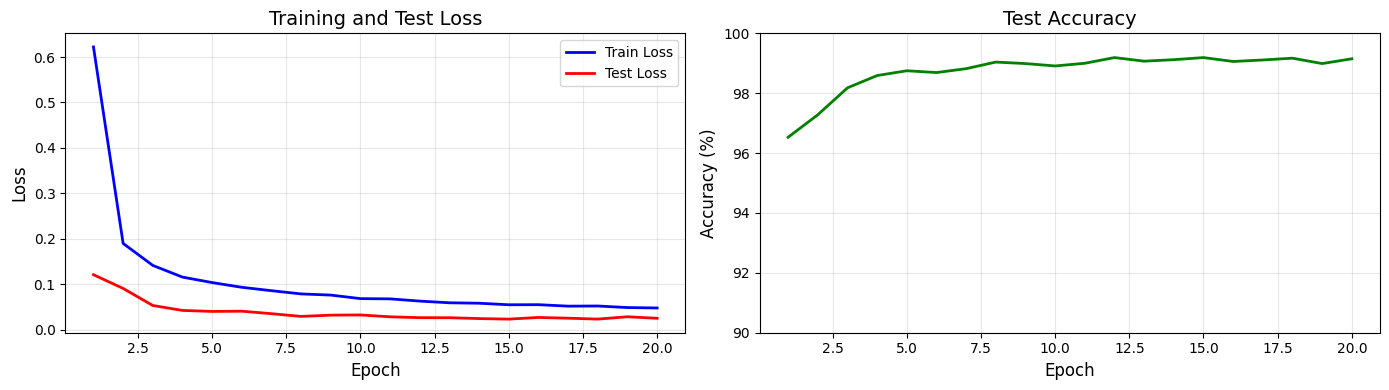


Epoch [20/20] Summary:
  Train Loss: 0.0478
  Test Loss: 0.0251
  Test Accuracy: 99.15%



In [44]:
#@title Training the model with live visualization

# Lists to store metrics
train_losses = []
test_losses = []
test_accuracies = []
epochs_list = []

# Function to evaluate on test set
def evaluate_model():
    net.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for images, labels in test_gen:
            # For CNN: reshape to (batch, channels, height, width)
            images = Variable(images)  # Already in correct shape from DataLoader
            labels = Variable(labels)
            
            outputs = net(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_gen)
    accuracy = 100 * correct / total
    net.train()
    return avg_loss, accuracy

# Function to plot metrics
def plot_metrics():
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Plot losses
    ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Test Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy (logarithmic scale)
    ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Test Accuracy', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([90, 100])
    
    plt.tight_layout()
    plt.show()
    
# Training loop
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    num_batches = 0
    
    for i, (images, labels) in enumerate(train_gen):
        # For CNN: keep images in (batch, channels, height, width) format
        images = Variable(images)  # Already in correct shape from DataLoader
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / num_batches
    
    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model()
    
    # Store metrics
    epochs_list.append(epoch + 1)
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Plot metrics
    plot_metrics()
    print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Test Loss: {test_loss:.4f}')
    print(f'  Test Accuracy: {test_accuracy:.2f}%\n')

FINAL MODEL PERFORMANCE
Best Test Accuracy: 99.19%
Final Test Accuracy: 99.15%
Final Train Loss: 0.0478
Final Test Loss: 0.0251


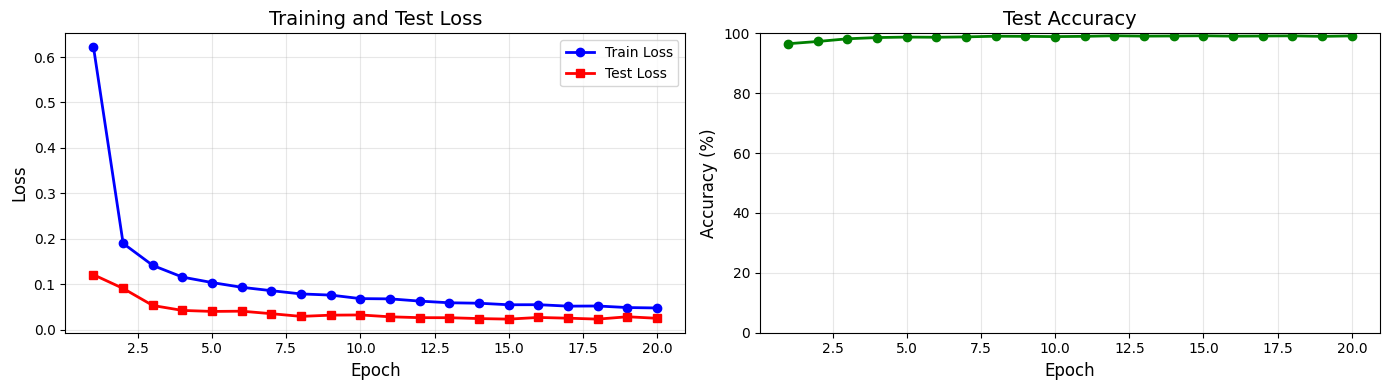

In [45]:
#@title Final Evaluation Summary

print('='*60)
print('FINAL MODEL PERFORMANCE')
print('='*60)
print(f'Best Test Accuracy: {max(test_accuracies):.2f}%')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print('='*60)

# Re-plot final metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot losses
ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2, marker='o')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

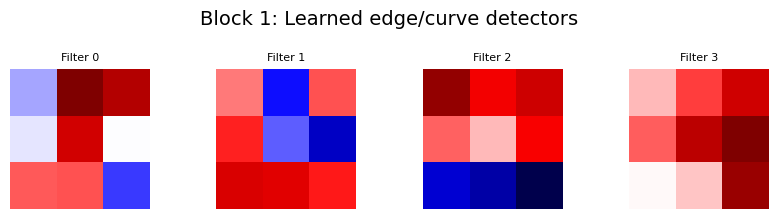

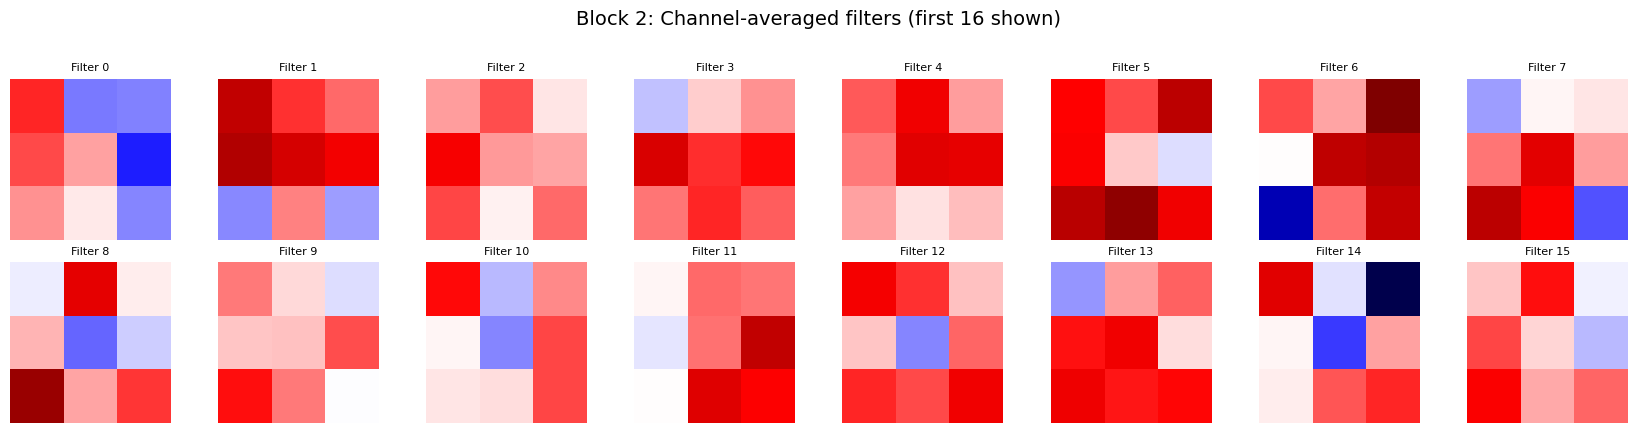

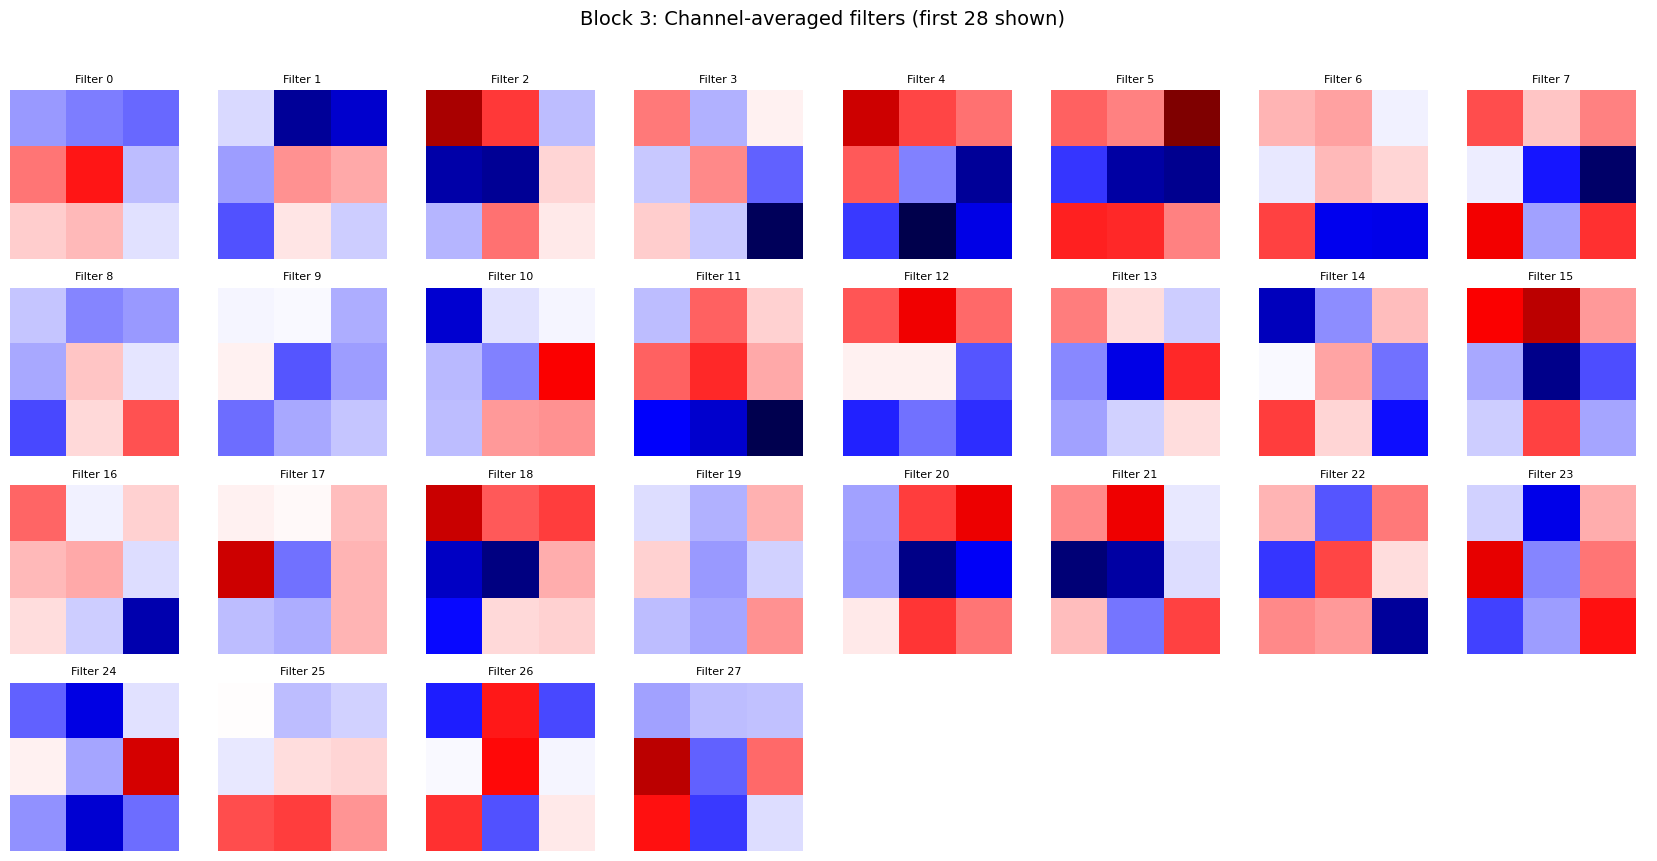

Each tile shows a single convolution filter. Blue/red indicates negative/positive weights.


In [60]:
#@title Visualize Learned Convolution Filters

import math
import numpy as np

net.eval()
conv_layers = [layer for layer in net.features if isinstance(layer, nn.Conv2d)]

if len(conv_layers) == 0:
    raise RuntimeError("This notebook expects the CNN to contain convolutional layers.")


def plot_filter_grid(weight_maps, title):
    num_filters = weight_maps.shape[0]
    cols = min(8, num_filters)
    rows = int(math.ceil(num_filters / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.1, rows * 2.1))
    fig.suptitle(title, fontsize=14, y=1.02)
    axes = np.array(axes).reshape(rows, cols)

    vmin = weight_maps.min().item()
    vmax = weight_maps.max().item()

    for idx, ax in enumerate(axes.flat):
        if idx < num_filters:
            ax.imshow(weight_maps[idx], cmap='seismic', vmin=vmin, vmax=vmax)
            ax.set_title(f'Filter {idx}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# First block operates on grayscale pixels, so we can view filters directly
first_filters = conv_layers[0].weight.data.detach().cpu()
plot_filter_grid(first_filters[:, 0], 'Block 1: Learned edge/curve detectors')

# Deeper blocks have multi-channel inputs. We average across channels to inspect the pattern.
for block_idx, conv in enumerate(conv_layers[1:], start=2):
    weights = conv.weight.data.detach().cpu().mean(dim=1)
    plot_filter_grid(weights, f'Block {block_idx}: Channel-averaged filters (first {weights.shape[0]} shown)')

print('Each tile shows a single convolution filter. Blue/red indicates negative/positive weights.')



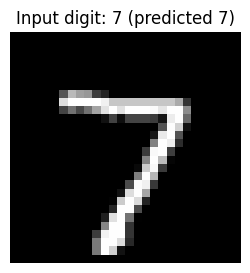

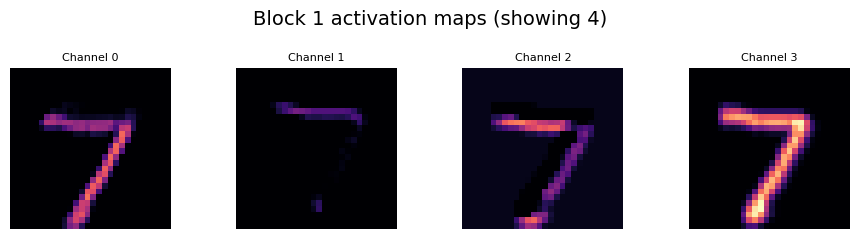

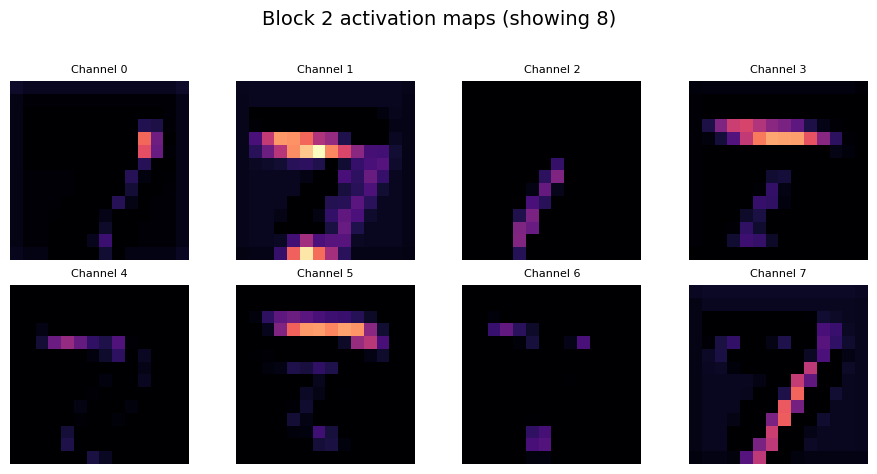

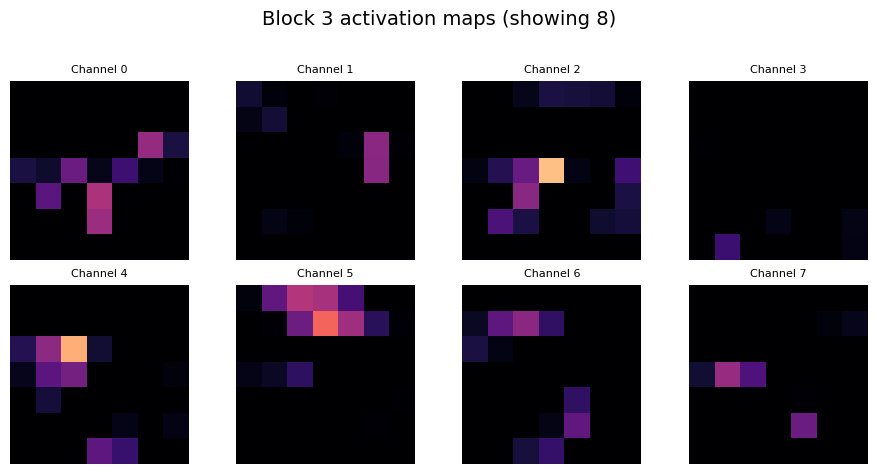

Bright regions show where the network is attending after each convolution block.


In [61]:
#@title Visualize Activation Maps on a Test Digit

import math
import numpy as np

net.eval()
device = next(net.parameters()).device

# Grab a single test image
sample_images, sample_labels = next(iter(test_gen))
input_image = sample_images[0:1].to(device)
true_label = sample_labels[0].item()

with torch.no_grad():
    prediction = torch.argmax(net(input_image), dim=1).item()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(sample_images[0].squeeze(), cmap='gray')
ax.set_title(f'Input digit: {true_label} (predicted {prediction})')
ax.axis('off')
plt.show()

# Pass the image through each block and store activation maps right after ReLU
activations = []
current = input_image.clone()
block_idx = 0
for layer in net.features:
    current = layer(current)
    if isinstance(layer, nn.ReLU):
        block_idx += 1
        activations.append((block_idx, current.detach().cpu()))


def plot_activation_maps(block_id, activation_tensor):
    """Plot a subset of activation maps for a given block."""
    num_maps = min(8, activation_tensor.shape[1])
    cols = 4
    rows = int(math.ceil(num_maps / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.3, rows * 2.3))
    fig.suptitle(f'Block {block_id} activation maps (showing {num_maps})', fontsize=14, y=1.02)
    axes = np.array(axes).reshape(rows, cols)

    act_min = activation_tensor.min().item()
    act_max = activation_tensor.max().item()

    for idx, ax in enumerate(axes.flat):
        if idx < num_maps:
            ax.imshow(activation_tensor[0, idx], cmap='magma', vmin=act_min, vmax=act_max)
            ax.set_title(f'Channel {idx}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

for block_id, activation_tensor in activations:
    plot_activation_maps(block_id, activation_tensor)

print('Bright regions show where the network is attending after each convolution block.')



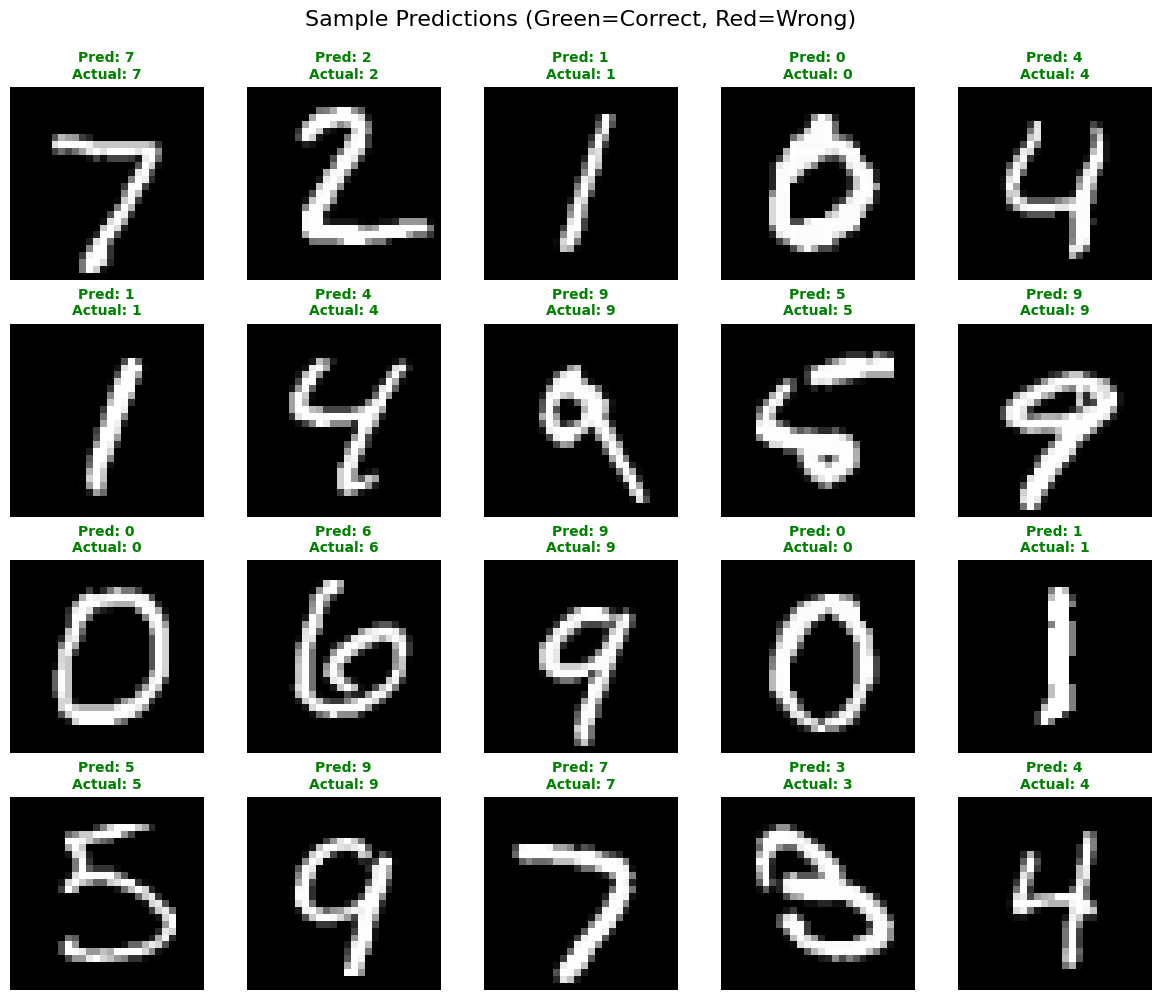


Batch Statistics:
Correct predictions: 100/100 (100.0%)


In [46]:
#@title Visualize Sample Predictions

import numpy as np

# Get a batch of test images
dataiter = iter(test_gen)
images, labels = next(dataiter)

# Make predictions
net.eval()
with torch.no_grad():
    # CNN expects (batch, channels, height, width)
    images_input = Variable(images)
    outputs = net(images_input)
    _, predicted = torch.max(outputs.data, 1)

# Convert to numpy for plotting
images_np = images.numpy()
predicted_np = predicted.numpy()
labels_np = labels.numpy()

# Plot 20 samples (4 rows x 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=16, y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(images_np):
        # Display image
        ax.imshow(images_np[idx].squeeze(), cmap='gray')
        
        # Check if prediction is correct
        is_correct = predicted_np[idx] == labels_np[idx]
        color = 'green' if is_correct else 'red'
        
        # Set title with prediction and actual label
        title = f'Pred: {predicted_np[idx]}\nActual: {labels_np[idx]}'
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics for this batch
num_correct = (predicted_np == labels_np).sum()
print(f'\nBatch Statistics:')
print(f'Correct predictions: {num_correct}/{len(labels_np)} ({100*num_correct/len(labels_np):.1f}%)')


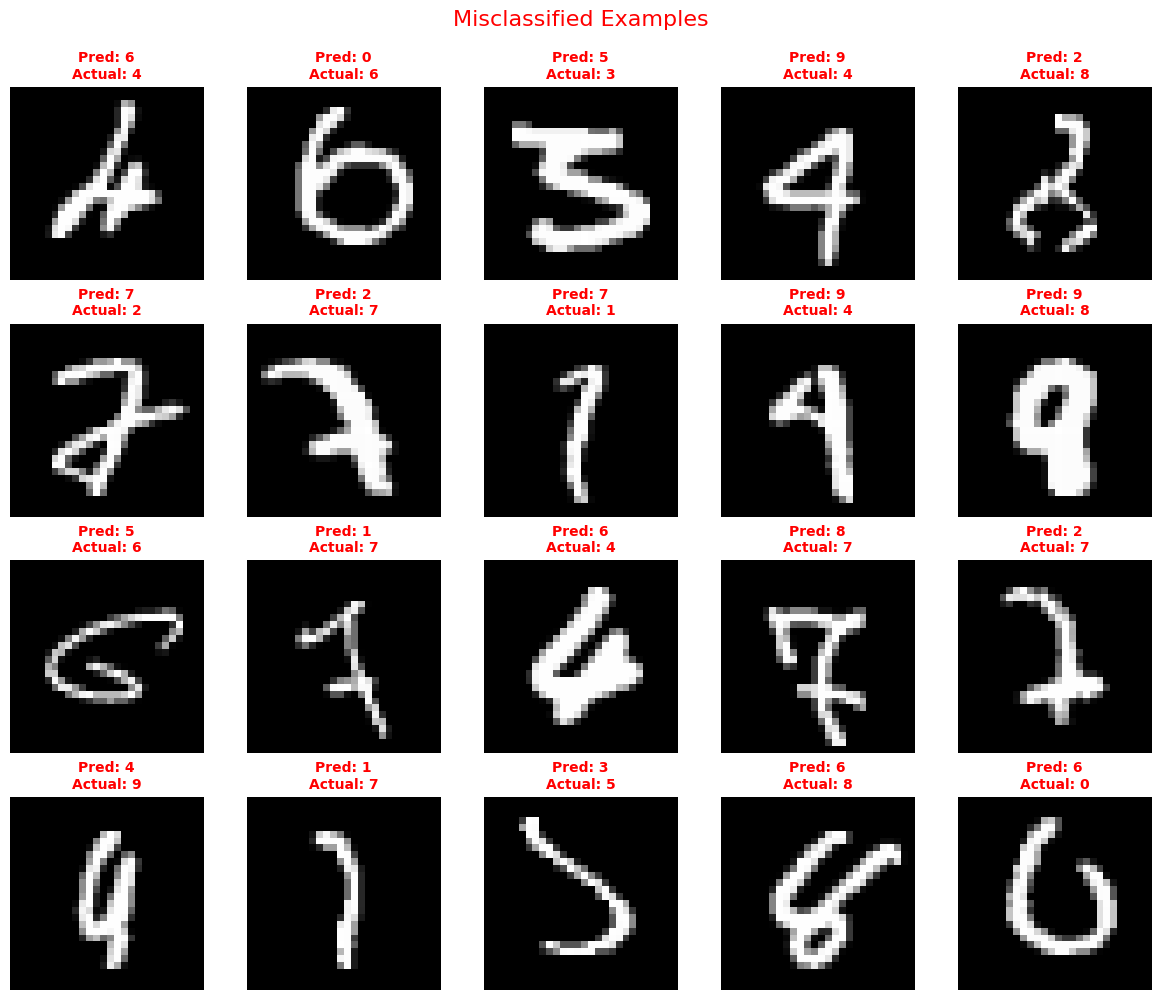


Showing 20 misclassified examples
These are cases where the model made mistakes.
Analyzing these can help identify patterns in model errors.


In [47]:
#@title Find and Display Misclassified Examples

# Collect misclassified examples
net.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_gen:
        # CNN expects (batch, channels, height, width)
        images_input = Variable(images)
        outputs = net(images_input)
        _, predicted = torch.max(outputs.data, 1)
        
        # Find misclassified samples in this batch
        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        
        for idx in wrong_idx:
            if len(misclassified_images) < 20:  # Collect up to 20 examples
                misclassified_images.append(images[idx].numpy())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())
        
        if len(misclassified_images) >= 20:
            break

# Plot misclassified examples
if len(misclassified_images) > 0:
    num_examples = min(20, len(misclassified_images))
    rows = (num_examples + 4) // 5  # Calculate needed rows
    
    fig, axes = plt.subplots(rows, 5, figsize=(12, 2.5*rows))
    fig.suptitle('Misclassified Examples', fontsize=16, color='red', y=0.995)
    
    # Flatten axes if needed
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_examples:
            # Display image
            ax.imshow(misclassified_images[idx].squeeze(), cmap='gray')
            
            # Set title with prediction and actual label
            title = f'Pred: {misclassified_preds[idx]}\nActual: {misclassified_labels[idx]}'
            ax.set_title(title, fontsize=10, color='red', weight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nShowing {num_examples} misclassified examples')
    print('These are cases where the model made mistakes.')
    print('Analyzing these can help identify patterns in model errors.')
else:
    print('No misclassified examples found in the test set!')


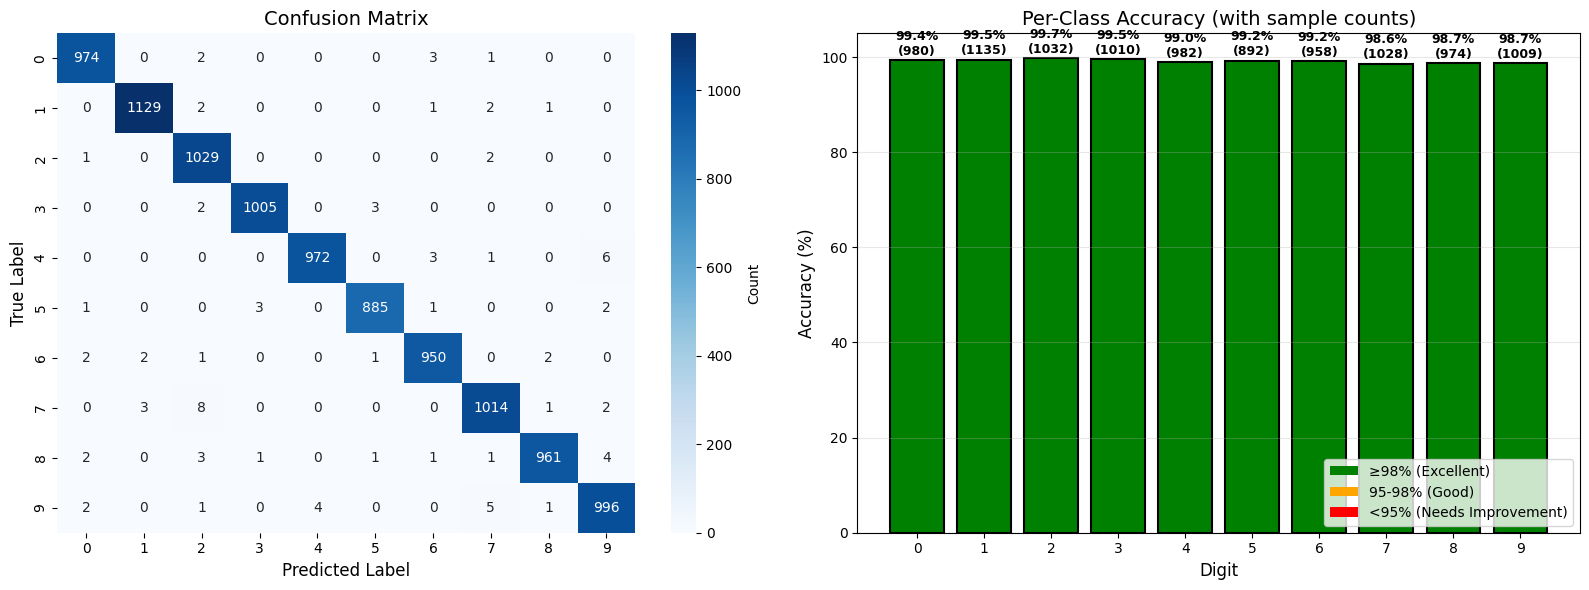


PER-CLASS PERFORMANCE
Digit    Accuracy     Correct/Total   Errors
------------------------------------------------------------
0         99.39%       974/980            6
1         99.47%      1129/1135           6
2         99.71%      1029/1032           3
3         99.50%      1005/1010           5
4         98.98%       972/982           10
5         99.22%       885/892            7
6         99.16%       950/958            8
7         98.64%      1014/1028          14
8         98.67%       961/974           13
9         98.71%       996/1009          13

Overall Accuracy: 99.15%

Most Confused Pairs (where model makes mistakes):
1. Digit 7 misclassified as 2: 8 times
2. Digit 4 misclassified as 9: 6 times
3. Digit 9 misclassified as 7: 5 times
4. Digit 8 misclassified as 9: 4 times
5. Digit 9 misclassified as 4: 4 times


In [48]:
#@title Confusion Matrix and Per-Class Accuracy

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and labels
net.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_gen:
        # CNN expects (batch, channels, height, width)
        images_input = Variable(images)
        outputs = net(images_input)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate per-class accuracy
class_accuracies = []
class_totals = []
for digit in range(10):
    digit_mask = all_labels == digit
    digit_correct = (all_predictions[digit_mask] == digit).sum()
    digit_total = digit_mask.sum()
    class_totals.append(digit_total)
    accuracy = 100 * digit_correct / digit_total if digit_total > 0 else 0
    class_accuracies.append(accuracy)

# Plot confusion matrix and per-class accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title('Confusion Matrix', fontsize=14)

# Per-Class Accuracy
digits = list(range(10))
colors = ['green' if acc >= 98 else 'orange' if acc >= 95 else 'red' for acc in class_accuracies]
bars = ax2.bar(digits, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc, total) in enumerate(zip(bars, class_accuracies, class_totals)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.1f}%\n({total})',
            ha='center', va='bottom', fontsize=9, weight='bold')

ax2.set_xlabel('Digit', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Per-Class Accuracy (with sample counts)', fontsize=14)
ax2.set_ylim([0, 105])
ax2.set_xticks(digits)
ax2.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='≥98% (Excellent)'),
    Patch(facecolor='orange', label='95-98% (Good)'),
    Patch(facecolor='red', label='<95% (Needs Improvement)')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print statistics
print(f'\n{"="*60}')
print('PER-CLASS PERFORMANCE')
print(f'{"="*60}')
print(f'{"Digit":<8} {"Accuracy":<12} {"Correct/Total":<15} {"Errors"}')
print(f'{"-"*60}')
for digit in range(10):
    digit_mask = all_labels == digit
    digit_correct = (all_predictions[digit_mask] == digit).sum()
    digit_total = digit_mask.sum()
    digit_errors = digit_total - digit_correct
    accuracy = 100 * digit_correct / digit_total if digit_total > 0 else 0
    print(f'{digit:<8} {accuracy:>6.2f}%      {digit_correct:>4}/{digit_total:<8}    {digit_errors:>4}')

print(f'\n{"="*60}')
print(f'Overall Accuracy: {100 * (all_predictions == all_labels).sum() / len(all_labels):.2f}%')
print(f'{"="*60}')

print(f'\nMost Confused Pairs (where model makes mistakes):')
# Find most confused pairs
confused_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (true_label, pred_label, count) in enumerate(confused_pairs[:5]):
    print(f'{i+1}. Digit {true_label} misclassified as {pred_label}: {count} times')
